# Analyzing NYC High School Data
We will work with the fillowing interrelated data sets about New York City public schools:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City

- [SAT scores by school](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City

- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school

- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school

- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information

- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school

- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

### Reading in the data

In [ ]:
# reading in the CSV files

import pandas as pd
data_files = ["ap_2010.csv",
"class_size.csv",
"demographics.csv",
"graduation.csv",
"hs_directory.csv",
"sat_results.csv"]
data = {}
for file in data_files:
    data[file.replace('.csv', '')] = pd.read_csv(file)


In [ ]:
# Reading in the survey data

all_survey = pd.read_csv("survey_all .txt",delimiter="\t",encoding="windows-1252")
d75_survey = pd.read_csv("survey_d75.txt",delimiter="\t",encoding="windows-1252")
survey = pd.concat([all_survey,d75_survey],axis=0,sort=True)


### Cleaning the Data

In [ ]:
# Cleaning Up the Surveys

survey["DBN"]=survey["DBN"]
survey = survey.loc[:,["DBN","rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]]
data["survey"] = survey

In [ ]:
# Inserting DBN Fields

data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad(n):
    if len(str(n)) > 1:
        return str(n)
    else:

        return str(n).zfill(2)
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]
data['class_size']['DBN']

In [ ]:
# Combining the SAT Scores

cols = ["SAT Math Avg. Score","SAT Critical Reading Avg. Score","SAT Writing Avg. Score"]
for col in cols:
    data["sat_results"][col] = pd.to_numeric(data["sat_results"][col],errors="coerce")

data["sat_results"]["sat_score"] = data["sat_results"][cols[0]] + data["sat_results"][cols[1]] + data["sat_results"][cols[2]]

In [ ]:
# Parsing Geographic Coordinates for Schools

import re

def get_lat(location):
    return re.findall("\(.+\)",location)[0].split(",")[0].replace('(',"")

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(get_lat)

def get_lon(location):
    return re.findall("\(.+\)",location)[0].split(",")[1].replace(')',"")

data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(get_lon)

### Condensing the Class Size Data Set

In [ ]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']

### Condensing the Demographics Data Set

In [ ]:
demographics = data["demographics"]
demographics = demographics[demographics['schoolyear'] == 20112012]
demographics.head()

In [ ]:
data["demographics"] = demographics

In [ ]:
data["graduation"] = data["graduation"][data["graduation"]['Cohort'] == '2006']
data["graduation"] = data["graduation"][data["graduation"]['Demographic'] == 'Total Cohort']

### Converting AP Test Scores

In [ ]:
cols = ['AP Test Takers ', 'Total Exams Taken','Number of Exams with scores 3 4 or 5']
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Performing the Left Joins

In [ ]:
combined = data["sat_results"]
combined = combined.merge(data["ap_2010"], on='DBN',how= 'left')
combined = combined.merge(data["graduation"], on='DBN',how= 'left')

### Performing the Inner Joins

In [ ]:
to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

for i in to_merge:
    combined = combined.merge(data[i], on='DBN',how= 'inner')

### Filling in Missing Values

In [ ]:
combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Adding a School District Column for Mapping

In [ ]:
def get_first_two(str):
    return str[0:2]
combined["school_dist"] = combined["DBN"].apply(get_first_two)
combined.head()

# Exploring the Data
### Finding correlations

In [ ]:
correlations = combined.corr()
correlations = correlations["sat_score"]
correlations

### Plotting survey correlations

In [ ]:
import warnings
warnings.filterwarnings('ignore')
survey_fields = ["rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]
combined.corr()["sat_score"][survey_fields].plot.bar()

### Exploring Safety and SAT Scores

<Axes: xlabel='saf_s_11', ylabel='sat_score'>

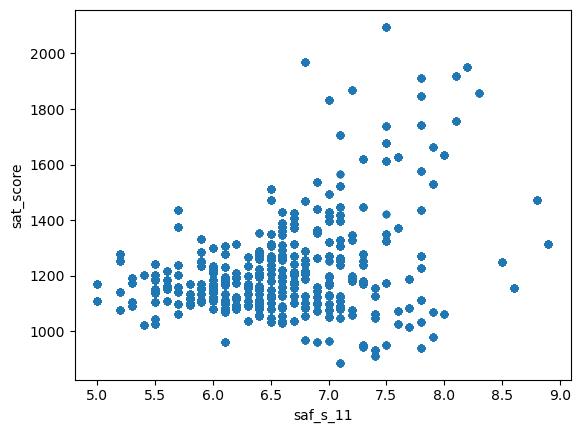

In [77]:
combined.plot.scatter("saf_s_11", "sat_score")

### Exploring Race and SAT Scores

<Axes: >

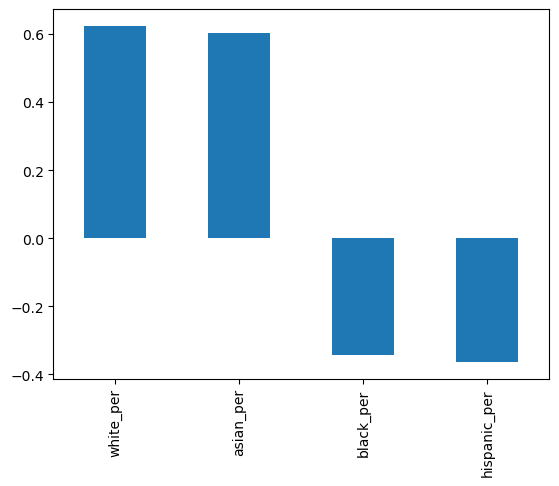

In [78]:
combined.corr()["sat_score"][["white_per", "asian_per", "black_per", "hispanic_per"]].plot.bar()


<Axes: xlabel='hispanic_per', ylabel='sat_score'>

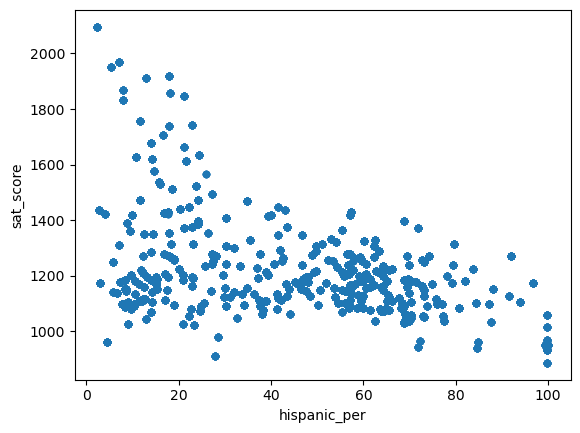

In [79]:
combined.plot.scatter("hispanic_per", "sat_score")

<Axes: xlabel='male_per', ylabel='sat_score'>

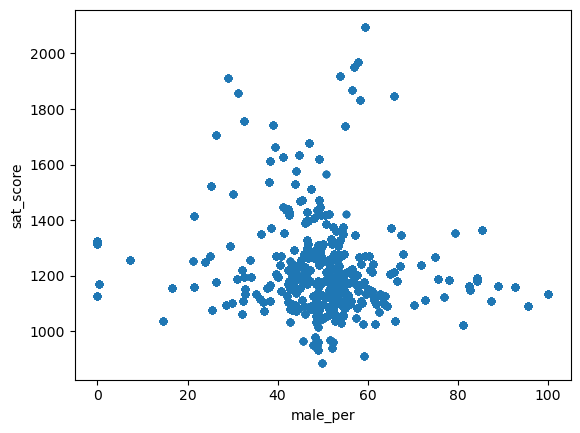

In [82]:
combined.plot.scatter("male_per", "sat_score")

<Axes: xlabel='female_per', ylabel='sat_score'>

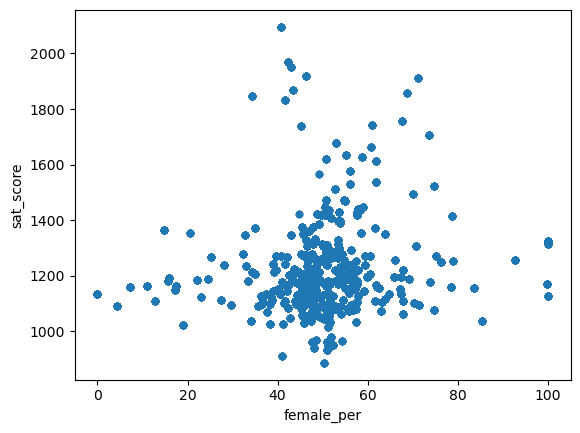

In [83]:
combined.plot.scatter("female_per", "sat_score")

### Exploring AP Scores vs. SAT Scores

<Axes: xlabel='ap_per', ylabel='sat_score'>

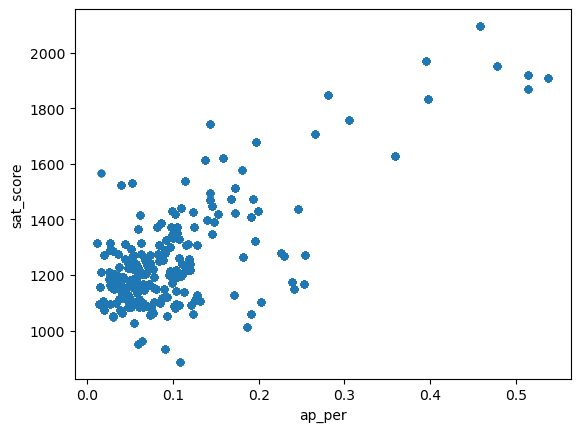

In [85]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')